<a href="https://colab.research.google.com/github/ksasi/EIP/blob/master/EIP4.0/Phase1/Session4%20-%20Assignments/Assignment4B_EIP4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -V

Python 3.6.9


In [2]:
!pip install tensorflow-gpu

In [3]:

import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import time
import matplotlib.pyplot as plt

% matplotlib inline
np.random.seed(2017) 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import eval
from tensorflow.keras import utils
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import backend as k
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

print(tf.version.VERSION)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [0]:
## tf.compat.v1.disable_eager_execution() ## https://github.com/tensorflow/tensorflow/issues/34235 and https://github.com/huan/tensorflow-handbook-tpu/issues/1 for TPU
tf.compat.v1.enable_eager_execution() ## To ensure tf-explain works after model is built. Strange issue with using TPU in colab.

In [0]:
num_classes = 10
batch_size = 512

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Image Augmentation and Image Standardization

In [0]:
def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)

In [0]:
def cutout(x: tf.Tensor, h: int, w: int, c: int = 3) -> tf.Tensor:
    """
    Cutout data augmentation. Randomly cuts a h by w whole in the image, and fill the whole with zeros.
    :param x: Input image.
    :param h: Height of the hole.
    :param w: Width of the hole
    :param c: Number of color channels in the image. Default: 3 (RGB).
    :return: Transformed image.
    """
    shape = tf.shape(x)
    x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32, seed= None)
    y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32, seed= None)
    x = replace_slice(x, tf.zeros([h, w, c]), [x0, y0, 0])
    return x

In [0]:
def random_pad_crop(x: tf.Tensor, y , pad_size = 4) -> tf.Tensor:
    """
    Randomly pad the image by `pad_size` at each border (top, bottom, left, right). Then, crop the padded image to its
    original size.
    :param x: Input image.
    :param pad_size: Number of pixels to pad at each border. For example, a 32x32 image padded with 4 pixels becomes a
                     40x40 image. Then, the subsequent cropping step crops the image back to 32x32. Padding is done in
                     `reflect` mode.
    :return: Transformed image.
    """
    shape = tf.shape(x)
    x = tf.pad(x, [[pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='reflect')
    x = tf.image.random_crop(x, [shape[0], shape[1], 3])
    return x,y

In [0]:
cifar10_mean = np.array([0.4914, 0.4822, 0.4465])
cifar10_std = np.array([0.2023, 0.1994, 0.2010])

normalize = lambda x, y: (tf.cast(((x - cifar10_mean) / cifar10_std), tf.float32), y) # Perform image normalization

In [0]:
data_aug = lambda x, y: (tf.cast(cutout((tf.image.random_flip_left_right(tf.image.random_crop(tf.cast(x, tf.float32), [32, 32, 3]))), 8, 8), tf.float32), y)


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(normalize, num_parallel_calls = AUTOTUNE).map(data_aug, num_parallel_calls = AUTOTUNE).shuffle(len(x_train)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(normalize, num_parallel_calls = AUTOTUNE).shuffle(len(x_test)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### Create ResNet18 model

In [0]:
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

### Create the model

In [0]:
"""ResNet v1, v2, and segmentation models for Keras.
# Reference
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
- [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)
Reference material for extended functionality:
- [ResNeXt](https://arxiv.org/abs/1611.05431) for Tiny ImageNet support.
- [Dilated Residual Networks](https://arxiv.org/pdf/1705.09914) for segmentation support
- [Deep Residual Learning for Instrument Segmentation in
   Robotic Surgery](https://arxiv.org/abs/1703.08580)
  for segmentation support.
Implementation Adapted from: github.com/raghakot/keras-resnet
"""  # pylint: disable=E501
from __future__ import division

import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import Initializer
#from tensorflow.keras_applications.imagenet_utils import _obtain_input_shape

pytorch_default_init = tf.keras.initializers.VarianceScaling(scale=1.0 / 3, mode='fan_in', distribution='uniform')

def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", pytorch_default_init)
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(0.000125))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", pytorch_default_init)
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(0.000125))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer= pytorch_default_init,
                          kernel_regularizer=l2(0.000125),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer= pytorch_default_init,
                       kernel_regularizer=l2(0.000125),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer= pytorch_default_init,
                       kernel_regularizer=l2(0.000125),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier



def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            if initial_kernel_size==(3, 3) and i == 0:
                transition_strides[0] = (1, 1)
            else:
                transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model


def ResNet18(input_shape, classes):
    """#ResNet with 18 layers and v2 residual units
    ResNet with 18 layers and v1 residual units
    """
    #return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2], residual_unit='v1', initial_strides=(1, 1), initial_kernel_size = (3,3), initial_pooling=None)


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


def ResNet101(input_shape, classes):
    """ResNet with 101 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 23, 3])


def ResNet152(input_shape, classes):
    """ResNet with 152 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 8, 36, 3])

In [0]:
def lr_schedule(epoch):
  lr = np.interp(epoch, [0, 15, 15, 30, 35], [0.001, 0.1, 0.11, 0.005, 0])
  print(lr)
  return np.float32(lr)

### Train on TPU

In [16]:
import os

# TF 2.0
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_host(resolver.master())
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
#strategy = tf.distribute.MirroredStrategy()


with strategy.scope():
  model = ResNet18((32, 32, 3), 10)
  model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=lr_schedule(0.1), nesterov=True, momentum=0.9),
              metrics=['accuracy'])


model.summary()

INFO:tensorflow:Initializing the TPU system: 10.5.223.178:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.5.223.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9189317853431744710)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2568694145487713568)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6716820197687202514)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 13043190554984603288)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/devic

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
filepath = "/content/drive/My Drive/resnet18_v1_cifar10_50_tpu_epochs.h5"

In [0]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose = 1)

callbacks = [lr_scheduler, checkpoint]

### Train the model for 50 epochs using 1-cycle policy

In [21]:
from math import ceil

epochs = 50

start = time.time()

# Fit the model on the batches generated by datagen.flow().
#ResNet18_history = model.fit(train_generator, steps_per_epoch=ceil(len(x_train)/batch_size), validation_data=valid_generator, validation_steps=ceil(len(x_test)/batch_size), epochs=epochs, verbose=1, callbacks=callbacks)

ResNet18_history = model.fit(train_set, steps_per_epoch=1, validation_data=test_set, validation_steps=ceil(len(x_test)/batch_size), epochs=epochs, verbose=1, callbacks=callbacks)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

0.001

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/50
INFO:tensorflow:Running validation at fit epoch: 0
20/20 [==============================] - 11s 565ms/step

Epoch 00001: val_accuracy improved from -inf to 0.06770, saving model to /content/drive/My Drive/resnet18_v1_cifar10_50_tpu_epochs.h5
1/1 [==============================] - 84s 84s/step - loss: 2.6231 - accuracy: 0.0762 - val_loss: 2.5097 - val_accuracy: 0.0677
0.0076

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0076.
Epoch 2/50
INFO:tensorflow:Running validation at fit epoch: 1
20/20 [==============================] - 13s 627ms/step

Epoch 00002: val_accuracy improved from 0.06770 to 0.08330, saving model to /content/drive/My Drive/resnet18_v1_cifar10_50_tpu_epochs.h5
1/1 [==============================] - 78s 78s/step - loss: 2.5814 - accuracy: 0.1113 - val_loss: 2.5050 - val_accuracy: 0.0833
0.0142

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0142.
Epoch 

### Plot Model Accuracy & Model Loss

In [0]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

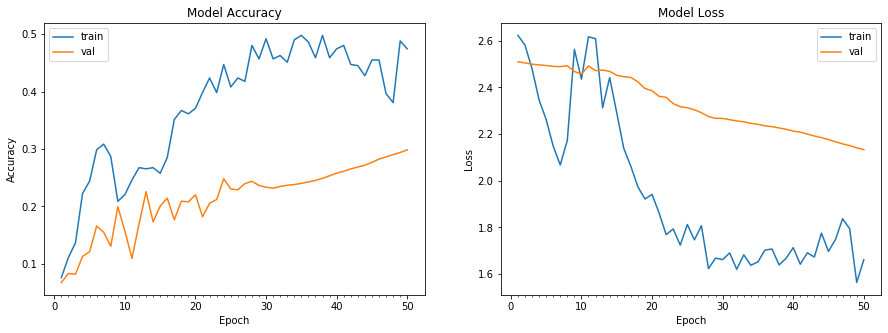

In [23]:
plot_model_history(ResNet18_history)

### Reload the model and obtain predictions

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/resnet18_v1_cifar10_50_tpu_epochs.h5')

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
y_pred = model.predict(x_test)
prediction_labels = np.argmax(y_pred, axis = -1)
actual_labels = np.argmax(y_test, axis = -1)

In [17]:
print(prediction_labels)

[3 0 0 ... 2 5 2]


In [0]:
idx_list = [742, 746, 766, 770, 720, 730, 755, 789, 810, 800]

### Install tf-explain. However override necessary methods as gradCAM generated image cannot be superimposed on the original image with necessary Opacity (https://github.com/sicara/tf-explain/issues/103). Also to use tf-explain with TPU and tf 2.0, rerun the notebook and enable eager mode. TPU with tf2.0 in colab works with **eager mode is disabled**. But tf-explain works with **eager mode enabled**

In [19]:
!pip install tf-explain
#!pip uninstall opencv-contrib-python
#!pip uninstall opencv-python

In [0]:
""" Module for display related operations. """
import math
import warnings

import cv2
import numpy as np


def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(
                Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
                )
            )
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate(
        [
            np.concatenate(
                array[index * num_columns : (index + 1) * num_columns], axis=1
            )
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid


def filter_display(array, num_rows=None, num_columns=None):
    """
    Display a list of filter outputs as a greyscale images grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    return grid_display(
        np.concatenate(np.rollaxis(array, 3, 1), axis=0), num_rows, num_columns
    )


def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")


def heatmap_display_modified(heatmap, original_image, colormap=cv2.COLORMAP_VIRIDIS):
    """
    Apply a heatmap (as an np.ndarray) on top of an original image.
    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply the heatmap
        colormap (int): OpenCV Colormap to use for heatmap visualization
    Returns:
        np.ndarray: Original image with heatmap applied
    """
    heatmap = cv2.resize(heatmap, original_image.shape[0:2])

    image = image_to_uint_255(original_image)

    heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())

    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap
    )

    output = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [0]:
"""
Core Module for Grad CAM Algorithm
"""
import cv2
import numpy as np
import tensorflow as tf

from tf_explain.utils.display import grid_display, heatmap_display
from tf_explain.utils.saver import save_rgb


class GradCAM_Modified:

    """
    Perform Grad CAM algorithm for a given input
    Paper: [Grad-CAM: Visual Explanations from Deep Networks
            via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
    """

    def explain(
        self,
        validation_data,
        model,
        layer_name,
        class_index,
        colormap=cv2.COLORMAP_VIRIDIS,
    ):
        """
        Compute GradCAM for a specific class index.
        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            layer_name (str): Targeted layer for GradCAM
            class_index (int): Index of targeted class
            colormap (int): OpenCV Colormap to use for heatmap visualization
        Returns:
            numpy.ndarray: Grid of all the GradCAM
        """
        images, _ = validation_data

        outputs, guided_grads = GradCAM_Modified.get_gradients_and_filters(
            model, images, layer_name, class_index
        )

        cams = GradCAM_Modified.generate_ponderated_output(outputs, guided_grads)

        heatmaps = np.array(
            [
                heatmap_display_modified(cam.numpy(), image, colormap)
                for cam, image in zip(cams, images)
            ]
        )

        grid = grid_display(heatmaps)

        return grid

    @staticmethod
    @tf.function
    def get_gradients_and_filters(model, images, layer_name, class_index):
        """
        Generate guided gradients and convolutional outputs with an inference.
        Args:
            model (tf.keras.Model): tf.keras model to inspect
            images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
            layer_name (str): Targeted layer for GradCAM
            class_index (int): Index of targeted class
        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
        """
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_outputs)

        guided_grads = (
            tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
        )

        return conv_outputs, guided_grads

    @staticmethod
    def generate_ponderated_output(outputs, grads):
        """
        Apply Grad CAM algorithm scheme.
        Inputs are the convolutional outputs (shape WxHxN) and gradients (shape WxHxN).
        From there:
            - we compute the spatial average of the gradients
            - we build a ponderated sum of the convolutional outputs based on those averaged weights
        Args:
            output (tf.Tensor): Target layer outputs, with shape (batch_size, Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (batch_size, Hl, Wl, Nf)
        Returns:
            List[tf.Tensor]: List of ponderated output of shape (batch_size, Hl, Wl, 1)
        """

        maps = [
            GradCAM_Modified.ponderate_output(output, grad)
            for output, grad in zip(outputs, grads)
        ]

        return maps

    @staticmethod
    def ponderate_output(output, grad):
        """
        Perform the ponderation of filters output with respect to average of gradients values.
        Args:
            output (tf.Tensor): Target layer outputs, with shape (Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (Hl, Wl, Nf)
        Returns:
            tf.Tensor: Ponderated output of shape (Hl, Wl, 1)
        """
        weights = tf.reduce_mean(grad, axis=(0, 1))

        # Perform ponderated sum : w_i * output[:, :, i]
        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

        return cam

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.
        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_rgb(grid, output_dir, output_name)

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

### Show gradCAM images

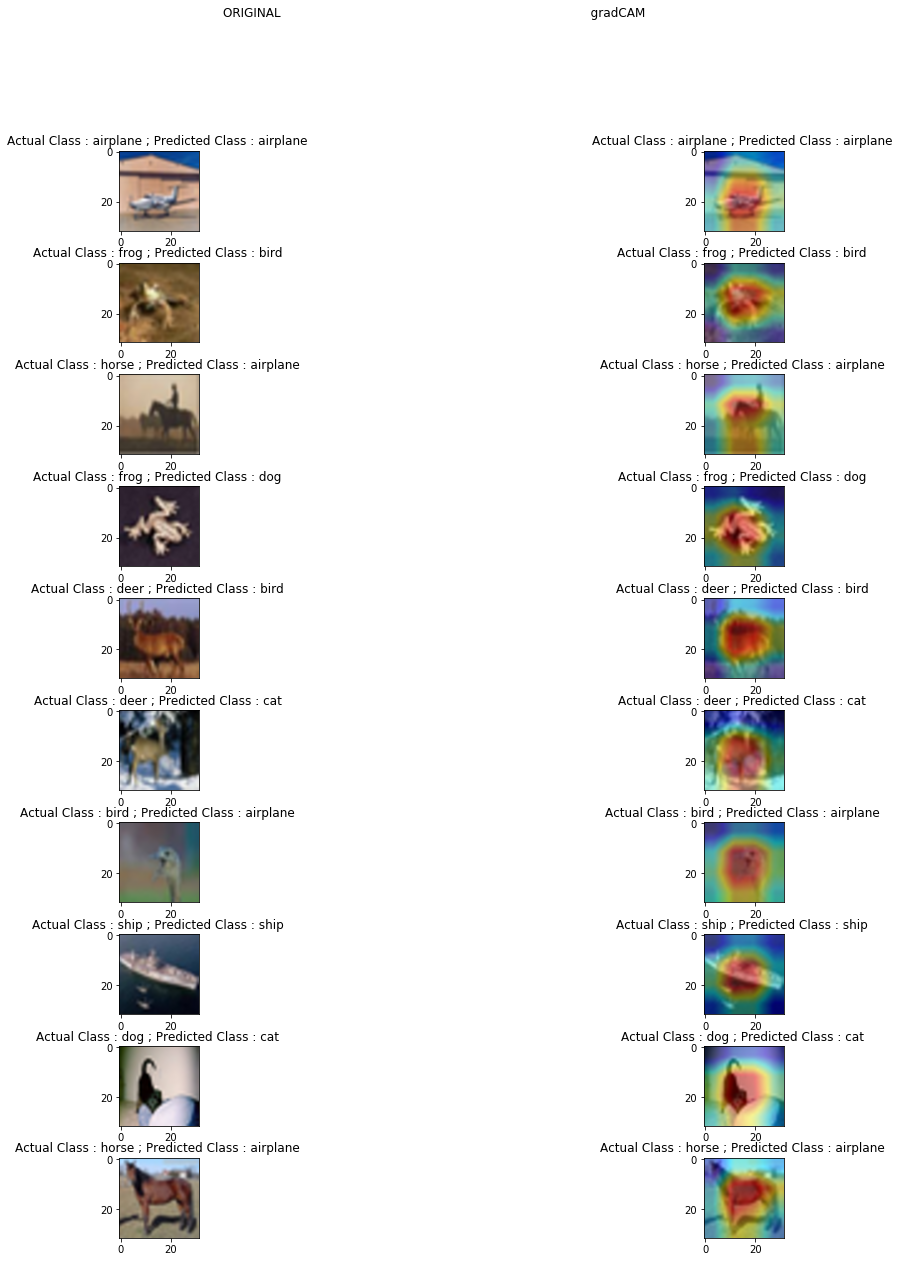

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from tf_explain.utils.display import grid_display, heatmap_display
#from tf_explain.core.grad_cam import GradCAM
import cv2

fig=plt.figure(figsize=(20, 20))
spec = gridspec.GridSpec(ncols=2, nrows=10, figure=fig)
columns = 2
rows = 10
for i in range(rows):
  for j in range(columns):
    idx = idx_list[i]
    img = x_test.reshape(x_test.shape[0], 32, 32, 3)[idx]
    data = ([img], None)
    fig.add_subplot(spec[i, j])
    #fig.subplots_adjust(left = 0.3, right = 0.7, bottom = 0.1, top = 1.1, hspace=0.4, wspace= 0.1)
    fig.subplots_adjust(hspace=0.4, wspace= 0.1)
    fig.suptitle("ORIGINAL                                                                                gradCAM")
    plt.title("Actual Class : {} ; Predicted Class : {} ".format(class_names[actual_labels[idx]],  class_names[prediction_labels[idx]]))
    #ax.set_title(class_names[prediction_labels[idx]])
    if j == 0:
      plt.imshow(img, interpolation = 'spline16')
    else:
      explainer = GradCAM_Modified()
      grid = explainer.explain(data, model, "conv2d_18", prediction_labels[idx], colormap=cv2.COLORMAP_JET)
      explainer.save(grid, ".", "grad_cam.png")
      gradCAM_img = plt.imread("grad_cam.png")
      plt.imshow(gradCAM_img, interpolation = 'spline16') 
      pass
plt.show()

### References :

*   Book Chapter: https://tf.wiki/zh/appendix/tpu.html
*   Chapter Github Repository: https://github.com/huan/tensorflow-handbook-tpu/
Huan (李卓桓), 2019



### To Do:


*   Tune the hyper parameters to obtain more than 90% validation accuracy
*   Resolve graph vs eager mode execution to use tf.explain for gradCAM. This may be possible after tf 2.1 is released, Colab and Colab-TPU systems were updated to use tf 2.1

